# Lightweight Marketing Mix Model

## Project Overview

Marketing Mix Modeling (MMM) has become an essential tool for understanding the incremental impact of marketing channels on business outcomes, enabling data-driven budget allocation and strategic decision-making. For this analysis, I implemented a Bayesian MMM approach using Google's LightweightMMM framework [1], leveraging the comprehensive API documentation provided in the repository [2]. The model provides a scalable and interpretable solution for measuring media effectiveness and optimizing marketing investments.

**Dataset Details:**

This model utilizes a dataset generated with the Aggregate Marketing System Simulator (AMASS), an open-source R package provided by Google for research purposes [3]. The AMASS tool simulates realistic marketing datasets. The source code for the AMASS package was obtained from the Google GitHub repository.

*   Initial Data: AMASS generated 228 rows of weekly data, representing 4 years.
Normalization Period: The first 104 rows were removed to allow the simulator time to normalize.
*   Final Dataset: The resulting dataset contains 104 rows, representing 2 years of weekly data.

This final dataset captures a balanced media budget allocation across traditional media, social media, search engine marketing (SEM), programmatic display advertising, direct mail, digital out-of-home (DOOH), and billboards.

**Media Variables Used:**

The dataset includes the following media variables:

*   dsp_tv
*   dsp_search
*   dsp_programmatic
*   dsp_social
*   dsp_ctv
*   dsp_directmail
*   dsp_dooh
*   dsp_billboard

**Holiday Variables Used:**

Merge weekly records with Canadian national holidays across the 52 weeks of the year. The holidays included are:

* New Year's Day (Week 1)
* Family Day (Week 7)
* Good Friday (Week 14)
* Victoria Day (Week 20)
* Canada Day (Week 26)
* Civic Holiday (Week 31)
* Labour Day (Week 36)
* Thanksgiving (Week 40)
* Remembrance Day (Week 45)
* Christmas Day (Week 51)
* Boxing Day (Week 51)

**References**

[1] Duque, P., Nachbar, D., Abe, Y., Ahlheim, C., Anderson, M., Sun, Y., Goldstein, O. and Eck, T. (2022) LightweightMMM: Lightweight (Bayesian) Marketing Mix Modeling. https://github.com/google/lightweight_mmm

[2] Duque, P., Nachbar, D., Abe, Y., Ahlheim, C., Anderson, M., Sun, Y., Goldstein, O. and Eck, T. (2022) LightweightMMM Models API Documentation. https://lightweight-mmm.readthedocs.io/en/latest/api.html

[3] Zhang, S. and Vaver, J. (2017) Introduction to the Aggregate Marketing System Simulator. https://research.google/pubs/introduction-to-the-aggregate-marketing-system-simulator/


## Install Packages

In [ ]:
##install
!pip install numpyro
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git

ERROR: Operation cancelled by user
  Cloning https://github.com/google/lightweight_mmm.git to /tmp/pip-req-build-6w41_t4t
  Running command git clone --filter=blob:none --quiet https://github.com/google/lightweight_mmm.git /tmp/pip-req-build-6w41_t4t
  Resolved https://github.com/google/lightweight_mmm.git to commit dd837006ac996028645b09cac93d320c8132003a
  Preparing metadata (setup.py) ... done


## Load Data

In [ ]:
#  Import relevant libraries

import jax.numpy as jnp
import numpyro
import pandas as pd
import numpy as np

#  Import data visualization libraries

import seaborn as sns
import matplotlib.pyplot as plt

#  Set style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
sns.color_palette('Paired')


#  Import model & evaluation modules from lightweight library

from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

In [ ]:
# Read AMASS data
mmm_data = pd.read_csv('mmm_data.csv')

# Read Holiday data
mmm_control = pd.read_csv('mmm_controlvar.csv')

# Merge the dataframes on the 'week' column
df = pd.merge(mmm_data, mmm_control, on='week', how='left')

In [ ]:
df.head()

,week,time.index,dsp_tv.volume,dsp_tv.spend,dsp_search.clicks,dsp_search.imps,dsp_search.matching.query.volume,dsp_search.query.volume,dsp_search.spend,dsp_programmatic.volume,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
0,1,53,0,0.000,0,0,4764432,21173199,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,54,429206124,2146076.516,355043,4499643,4499643,20008261,390547.3,451859686,...,0,0,0,0,0,0,0,0,0,0
2,3,55,0,0.000,264879,3496938,3496938,15543888,291366.9,0,...,0,0,0,0,0,0,0,0,0,0
3,4,56,249732614,1248641.648,314857,4054369,4054369,18013554,346342.7,262882556,...,0,0,0,0,0,0,0,0,0,0
4,5,57,0,0.000,329589,4224253,4224253,18767103,362547.9,0,...,0,0,0,0,0,0,0,0,0,0


## Organize Data for Modeling

In [ ]:
# 1. Media Variables
dsp_cols = [col for col in df.columns if 'dsp_' in col and '.spend' in col]

# 2. Control Variables
# Holiday Variables
hldy_cols = [col for col in df.columns if 'hldy_' in col]
# seasonality variables
seas_cols = [col for col in df.columns if 'seas_' in col]

control_vars =  hldy_cols + seas_cols

# 3. Sales Variables
sales_cols =['brand.sales']

df_main = df[['week'] + sales_cols + dsp_cols + control_vars]
df_main = df_main.rename(columns={'dsp_tv.spend': 'TV', 'dsp_search.spend': 'SEM', 'dsp_programmatic.spend': 'Online Display', 'dsp_social.spend': 'Social Media', 'dsp_olv.spend': 'Online Video', 'dsp_directmail.spend': 'Direct Mail', 'dsp_dooh.spend': 'Digital Out Of Home', 'dsp_billboard.spend': 'Billboard'})
dsp_cols = ['TV', 'SEM', 'Online Display', 'Social Media', 'Online Video', 'Direct Mail', 'Digital Out Of Home', 'Billboard']




In [ ]:
df_main.head()

,week,brand.sales,TV,SEM,Online Display,Social Media,Online Video,Direct Mail,Digital Out Of Home,Billboard,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
0,1,2005041,0.000,0.0,0.0000,173076.9231,0.000,269230.7692,173076.9231,144230.7692,...,0,0,0,0,0,0,0,0,0,0
1,2,2743823,2146076.516,390547.3,903611.1648,173076.9231,1242465.352,269230.7692,173076.9231,144230.7692,...,0,0,0,0,0,0,0,0,0,0
2,3,1408432,0.000,291366.9,0.0000,173076.9231,0.000,269230.7692,173076.9231,144230.7692,...,0,0,0,0,0,0,0,0,0,0
3,4,2295260,1248641.648,346342.7,525743.8517,173076.9231,722897.796,269230.7692,173076.9231,144230.7692,...,0,0,0,0,0,0,0,0,0,0
4,5,1758101,0.000,362547.9,0.0000,173076.9231,0.000,269230.7692,173076.9231,144230.7692,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
set_seed = 100

In [ ]:
data_size = len(df_main)

n_media_channels = len(dsp_cols)
n_extra_features = len(control_vars)
media_data = df_main[dsp_cols].to_numpy()
extra_features = df_main[control_vars].to_numpy()
target = df_main['brand.sales'].to_numpy()
costs = df_main[dsp_cols].sum().to_numpy()

I've preprocessed the data by normalizing the media, extra features, and target variables. Specifically, we divide each of these variables by their respective means, ensuring that their mean values become 1. This normalization makes the model agnostic to the scale of the inputs, allowing flexibility in using different units for the target variable (i.e., number of sales vs. monetary value of sales).

The media costs, however, are not directly used as inputs to the model. Instead, they are utilized to inform the prior distributions for the media variables, guiding the model's expectations during training. To align these costs with typical ranges observed in MMMs, they have been scaled down by multiplying by a factor of 0.15. For more details on how costs influence the model, refer to the model documentation.

We will split the dataset into training and testing sets. For this scenario, we'll reserve the last 6 months (i.e., 24 weeks) as the testing data.

In [ ]:
# Split and scale data.
test_data_period_size = 24
split_point = data_size - test_data_period_size

# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]

# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]

# Target
target_train = target[:split_point]

In [ ]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

## Tuning The Model

The default settings of LightweightMMM are designed to establish priors for the media channels' effects on the model. By default, the "spend/cost" of each media channel is used as a prior when sampling from a half-normal distribution. This helps guide the model's understanding of how media investments impact outcomes based on historical data.

To fine-tune these parameters for specific business use cases, I propose using an array multiplier that serves two key purposes:

1. Adjust the effect of a media channel on the KPI: This allows scaling the media channel's influence to better reflect its real-world contribution to the target metric.
2. Limit or reduce adstock decay: By controlling the decay rate of the adstock effect, the model can produce results that align more closely with realistic business scenarios, ensuring that the delayed impact of media spend remains within logical bounds.

This approach provides flexibility for adapting the model to different industries or marketing strategies.

In [ ]:
# Updated channel contribution weights
channel_contribution_weights = {
    'Social Media': 1,
    'TV': 0.5,
    'SEM': 1,
    'Online Display': 1,
    'Online Video': 1,
    'Direct Mail': 1,
    'Digital Out Of Home': 1,
    'Billboard': 1
}

mod_media_priors = jnp.array(list(channel_contribution_weights.values())) * costs

# Adstock lag weights
channel_adstock_weights = {
    'Social Media': 2.0,
    'TV': 2.0,
    'SEM': 0.01,  # SEM typically has little to no adstock decay
    'Online Display': 2.0,
    'Online Video': 2.0,
    'Direct Mail': 2.0,
    'Digital Out Of Home': 2.0,
    'Billboard': 2.0
}

adstock_lag_weight_priors = jnp.array(list(channel_adstock_weights.values()))

# Updated media concentration weights
media_concentration_weights = {
    'Social Media': 1,
    'TV': 0.8,
    'SEM': 0.5,
    'Online Display': 1,
    'Online Video': 1,
    'Direct Mail': 1,
    'Digital Out Of Home': 1,
    'Billboard': 1
}

media_concentration_weights_priors = jnp.array(list(media_concentration_weights.values()))

# Custom priors for lag weight and half-max effective concentration
custom_priors = {
    "lag_weight": numpyro.distributions.Beta(
        concentration1=adstock_lag_weight_priors,
        concentration0=jnp.ones(len(adstock_lag_weight_priors))
    ),
    "half_max_effective_concentration": numpyro.distributions.Gamma(
        concentration=media_concentration_weights_priors,
        rate=jnp.ones(len(media_concentration_weights_priors))
    )
}


## Training the model

**Model Training Parameters**

The currently available models are the following:
- hill_adstock
- adstock
- carryover

**Model Training Parameters**

Mandatory Parameters [2]:

- media: Input data for media channels.
- total_costs: A single value representing the total cost for each media channel.
- target: The dependent variable the model aims to predict.

Optional Parameters:

- extra_features: Additional variables to include in the model for more nuanced predictions.
- degrees_seasonality: Specifies the number of degrees for modeling seasonality. The default value is 3.
- seasonality_frequency: Indicates the frequency of the time period being modeled. The default is 52, representing 52 weeks in a year.
- media_names: A list of names corresponding to the media channels included in the media parameter.
- number_warmup: Defines the number of warm-up samples for model training. The default value is 1000.
- number_samples: Specifies the number of samples to draw during the sampling process. The default is 1000.
- number_chains: Determines the number of chains to run for sampling. The default value is 2.

In [ ]:
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")

In [ ]:
# Fit the training data to the model
mmm.fit(media=media_data_train,
        extra_features=extra_features_train,
        media_prior=mod_media_priors,
        target=target_train,
        number_warmup=number_warmup,
        number_samples=number_samples,
        number_chains=1,
        custom_priors=custom_priors,
        media_names = dsp_cols,
        seed=set_seed)

sample: 100%|██████████| 2000/2000 [03:25<00:00,  9.73it/s, 395 steps of size 1.13e-03. acc. prob=0.92]


## Model Performance Checks

In [ ]:
# Print a summary:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]      0.00      0.00      0.00     -0.00      0.01     47.13      1.01
             coef_extra_features[1]      0.00      0.00      0.00     -0.00      0.00    181.23      1.00
             coef_extra_features[2]      0.27      0.60      0.27     -0.64      1.46     38.52      1.06
             coef_extra_features[3]     -0.03      0.66      0.01     -0.85      1.30     36.12      1.02
             coef_extra_features[4]      0.00      0.00     -0.00     -0.00      0.00     10.26      1.34
             coef_extra_features[5]     -0.00      0.00     -0.00     -0.00      0.00     46.49      1.04
             coef_extra_features[6]     -0.00      0.00     -0.00     -0.00      0.00     79.70      1.08
             coef_extra_features[7]      0.00      0.00      0.00     -0.00      0.00     43.84      1.14
             coef_extra_features[8]      0.00

**Model Fit**

These outcomes of the model fit suggest that the model is performing well overall, with strong predictive power and relatively low error. However, the the rigid nature of the simulated data
1. An R-squared of 0.913 indicates a strong fit, suggesting that the model is able to predict the KPI very accurately, leaving only a small portion of the variability unexplained
2. While the model's predictions are generally accurate, there is still an average error of roughly 9.17% between the predicted and true KPIs.


The strong fit could represent genuine model quality, however I think this is unlikely given this dataset likely has more predictable patterns than real-world data.

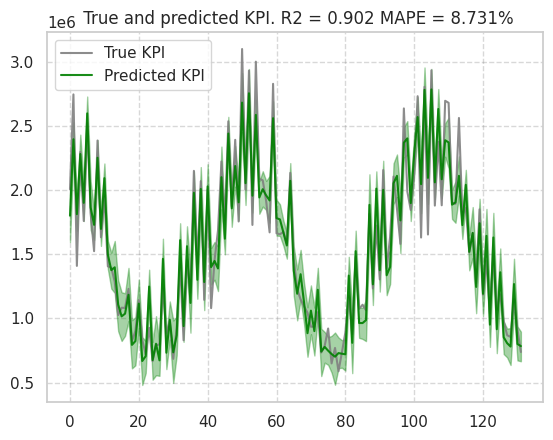

In [ ]:
# The target_train needs to be reshaped to match the predictions shape for plotting
plot.plot_model_fit(mmm, target_scaler=target_scaler) # Remove the target argument

**Priors and Posterior Plot**

Visualizing prior vs. posterior distribution comparison for model parameters reveals how initial assumptions evolved through data learning. This visualization shows which parameters the model was confident about versus those significantly updated by the data, providing transparency into model calibration and parameter uncertainty.

In [ ]:
plot.plot_prior_and_posterior(media_mix_model=mmm)

Output hidden; open in https://colab.research.google.com to view.

**Ad Stock Decay**

The adstock values below show how each media channel's impact decays over time, with smaller values indicating faster diminishing returns.

In [ ]:
pd.DataFrame({'channels':dsp_cols, 'adstock_decay':mmm.trace['lag_weight'].mean(axis=0)})

,channels,adstock_decay
0,TV,5.864214e-02
1,SEM,6.301161e-01
2,Online Display,4.045280e-21
3,Social Media,6.962246e-01
4,Online Video,6.236035e-01
5,Direct Mail,6.181549e-01
6,Digital Out Of Home,6.728356e-01
7,Billboard,5.955766e-01


**Variable Distributions**

The following posteriors show how confident the model is about each media channel's impact on brand sales.


The plot displays posterior distributions, the probability curves that show:
1. Peak of the curve: The most likely effect size for each channel
2. Width of the curve: How certain the model is (narrow = confident, wide = uncertain)


In [ ]:
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=dsp_cols)

#Model Output

## Media Performance Insights



In [ ]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

**Media Channel Contribution Over Time**

The following analysis examines media channel contributions and baseline effects using the Aggregate Marketing System Simulator (AMSS) dataset spanning a 24-month period. This temporal analysis allows us to understand how different marketing channels contribute to overall performance across seasonal variations and campaign cycles. The estimated media and baseline contributions are visualized below over time.


**Key Findings:**

1. Strong Brand Equity Foundation: The substantial blue baseline contribution demonstrates robust organic demand, indicating strong existing brand equity that provides a solid foundation for paid media amplification.

2. TV's Sharp Impact: The sharp spikes in TV contribution (gold) clearly correspond to campaign flights, showing TV's ability to create immediate, measurable lift above baseline. These spikes demonstrate TV's power for driving short-term activation while the broader seasonal curve shows sustained impact.

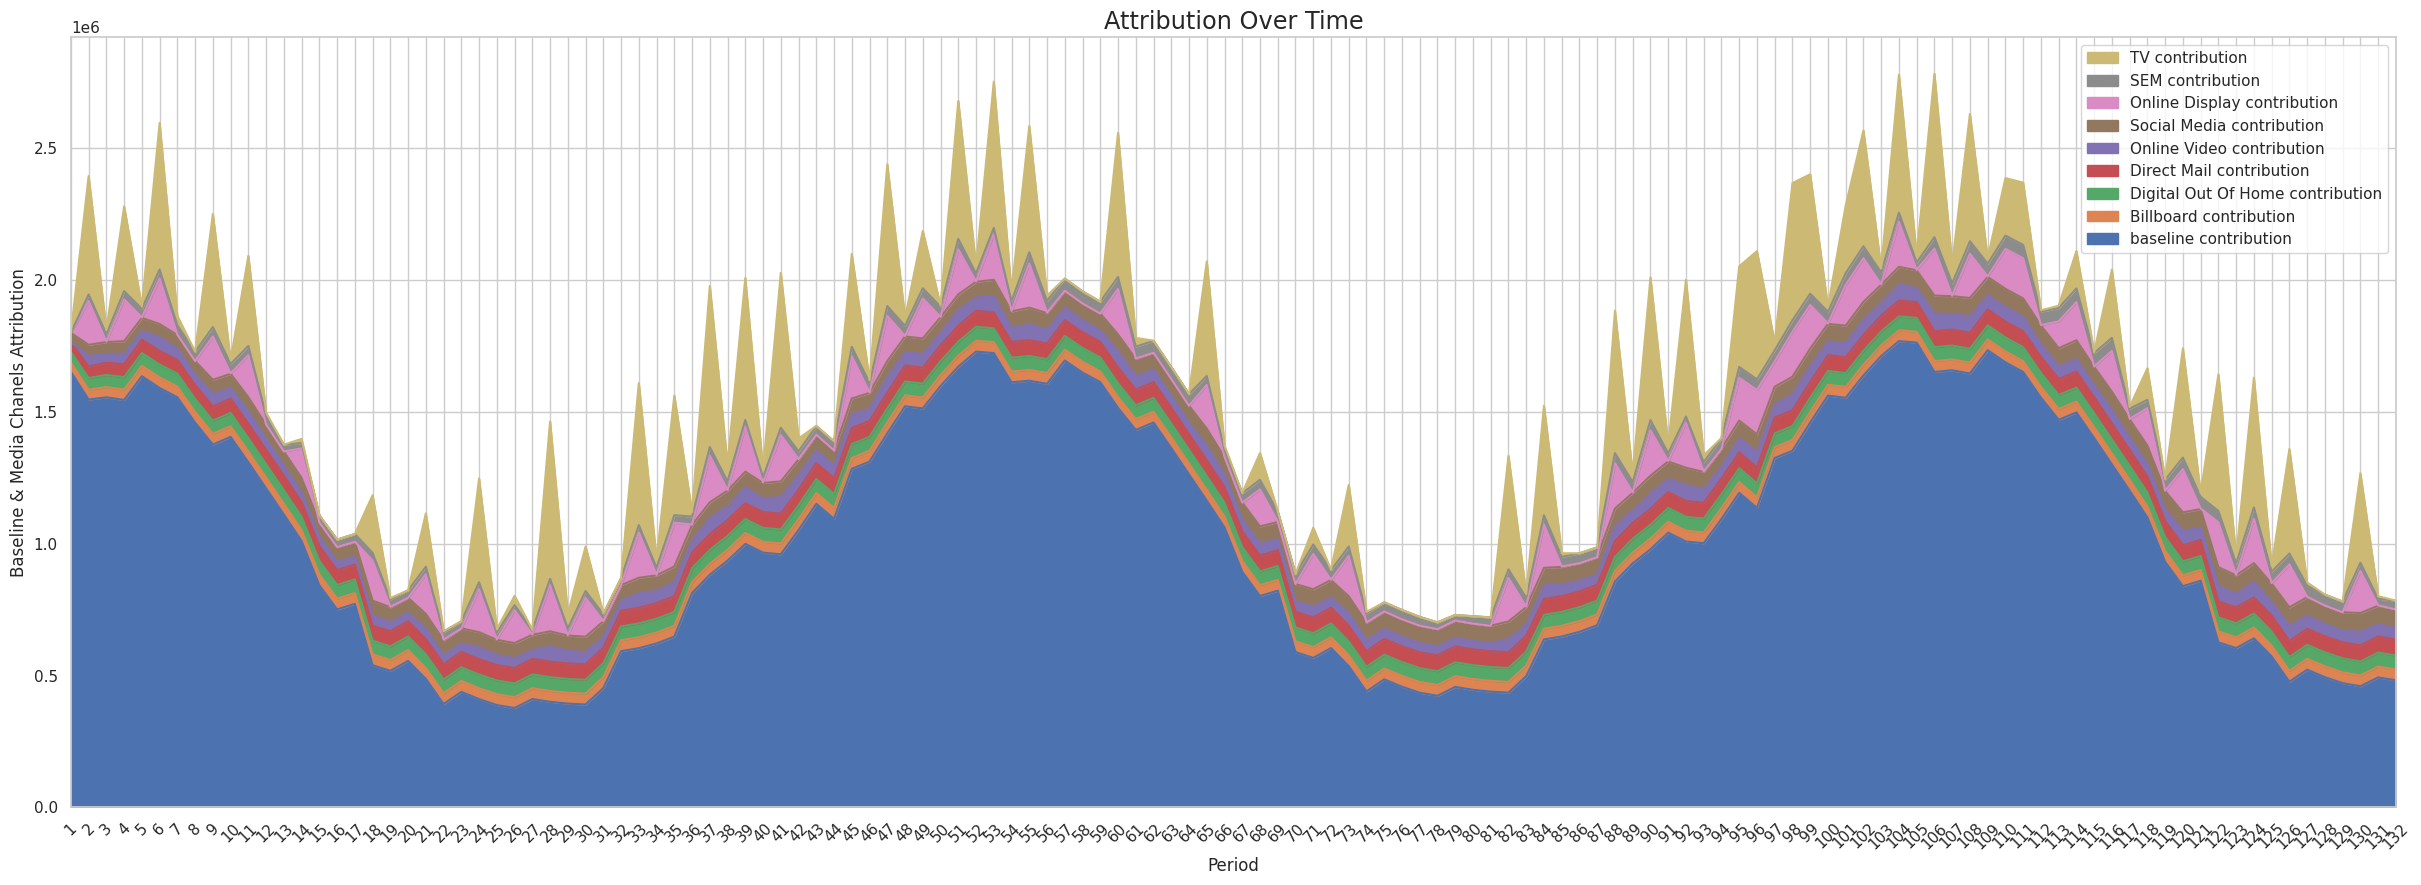

In [ ]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10),
                                                channel_names = dsp_cols
                                                )

**Channel Response Curves**

The response curves reveal the diminishing returns relationship with the target KPI (Brand Sales) for each media channel, showing how incremental investment translates to incremental KPI lift.

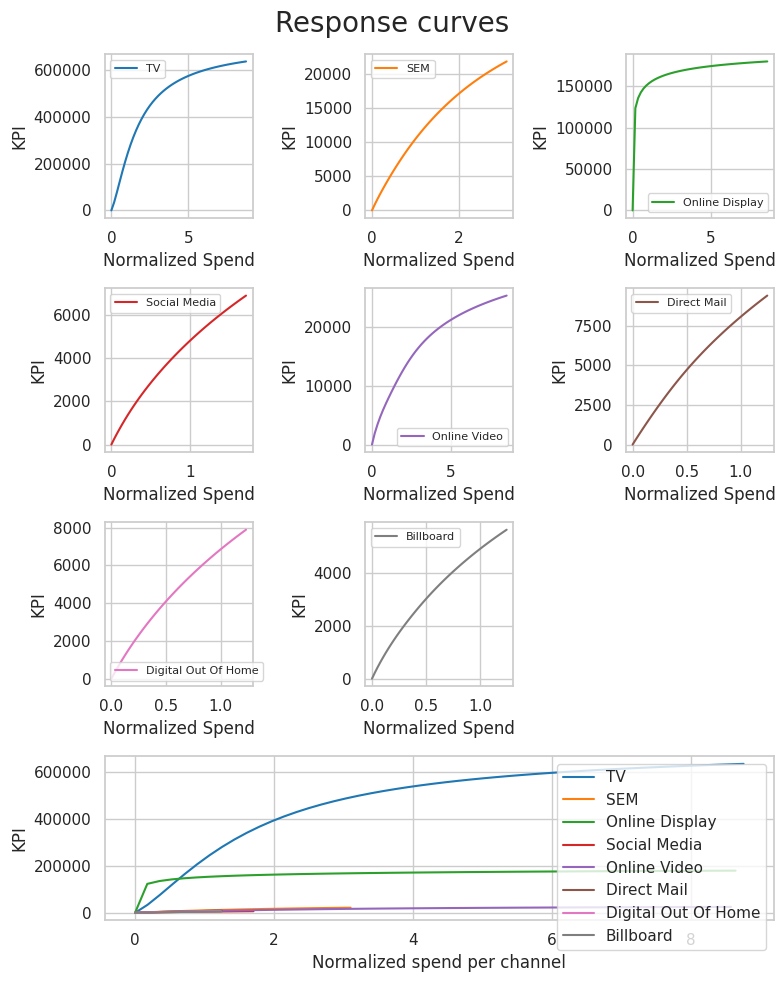

In [ ]:
plot.plot_response_curves(media_mix_model=mmm, target_scaler=target_scaler, seed=set_seed)

**Estimated Media Contribution Percentage**

Each media channel's estimated contribution to the target variable are visualized below with as percentage bars displaying credibility intervals. This displays the media contribution percentages for each channel.

**Strategic Findings**

1. TV dominates the media portfolio - At 11% contribution, TV is generating roughly 2-3x more impact than any other individual channel, which range between 2-5%. While SEM
2. This distribution pattern is fairly common in media mix models, where traditional channels like TV often show concentrated impact while digital channels distribute impact across multiple touchpoints.

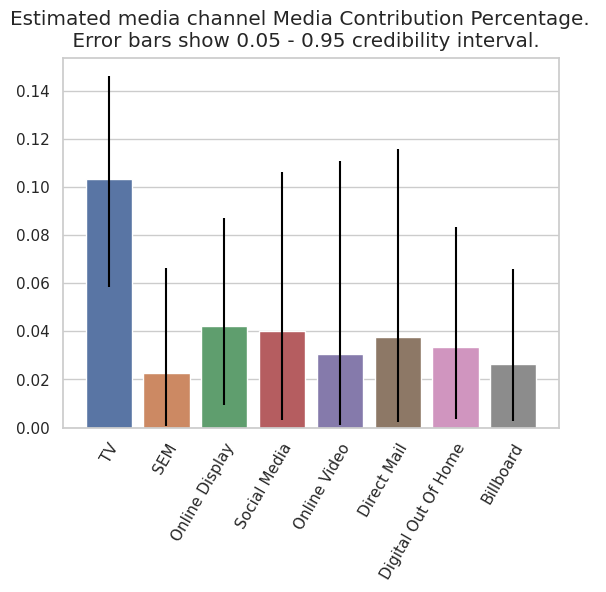

In [ ]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage", channel_names=dsp_cols)

**Estimated ROI by Channel**

The Return on Investment (ROI) estimates are provided below for different media channels with credibility intervals.

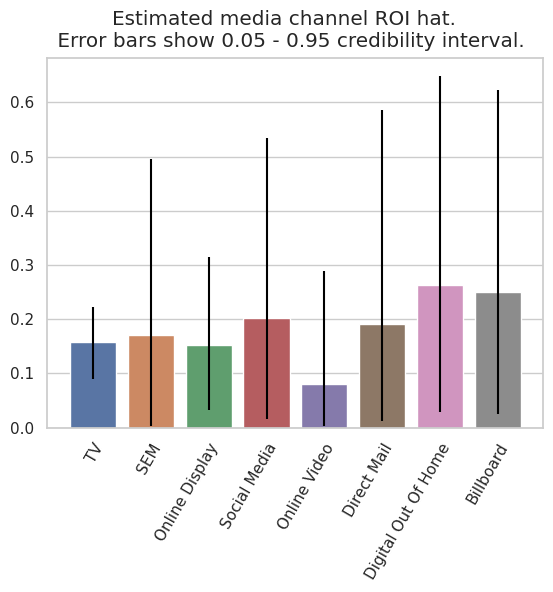

In [ ]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names=dsp_cols)

## Budget Optimization

This simulation framework enables comprehensive comparison of budget allocation strategies before and after optimization, providing insights into media channel effectiveness and target variable improvements.

This simulation compares before vs. after optimization scenarios, showing both budget reallocation recommendations and predicted KPI impact changes for each channel.

The optimization allocates budget efficiently over the specified timeframe (e.g., 12 weeks) by recommending reallocations within ±20% of your historical spend range - ensuring realistic, actionable changes. Adjust these bounds using bounds_lower_pct and bounds_upper_pct parameters (globally or per channel). Set prices to your average cost per media unit, or use 1s if your data is already in monetary terms.

In [ ]:
prices = jnp.ones(mmm.n_media_channels)

The budget represents the total amount you want to allocate over the specified number of time periods (n_time_periods). Ensure that the budget is in line with your historical spending; otherwise, some conditions or bounds in the optimization process might not be satisfied.

In [ ]:
n_time_periods = 12

budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

In [ ]:
# Run optimization with the chosen parameters.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=set_seed)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -23854860.531934563
            Iterations: 52
            Function evaluations: 867
            Gradient evaluations: 51


In [ ]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
print(optimal_buget_allocation)

# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
print(previous_budget_allocation)

# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

[1.5309884e+07 4.7095885e+06 5.1861815e+06 3.0904220e+06 5.9557130e+06
 4.4956030e+06 3.0325182e+06 1.8955692e+06]
[1.3082920e+07 4.9447770e+06 5.5361875e+06 3.7513150e+06 7.6340995e+06
 3.9933360e+06 2.5914108e+06 2.1414318e+06]


(Array(4.367548e+07, dtype=float32), Array(4.367548e+07, dtype=float32))

In [ ]:
# Validate that the budget constraint was met. Both numbers should be almost equal.
budget, jnp.sum(solution.x * prices)

(Array(4.367548e+07, dtype=float32), Array(4.367548e+07, dtype=float32))

Optimization impact visualization through:

1. Budget reallocation comparison that shows recommended spend changes per channel
2. KPI lift prediction that compares expected target variable performance before and after optimization

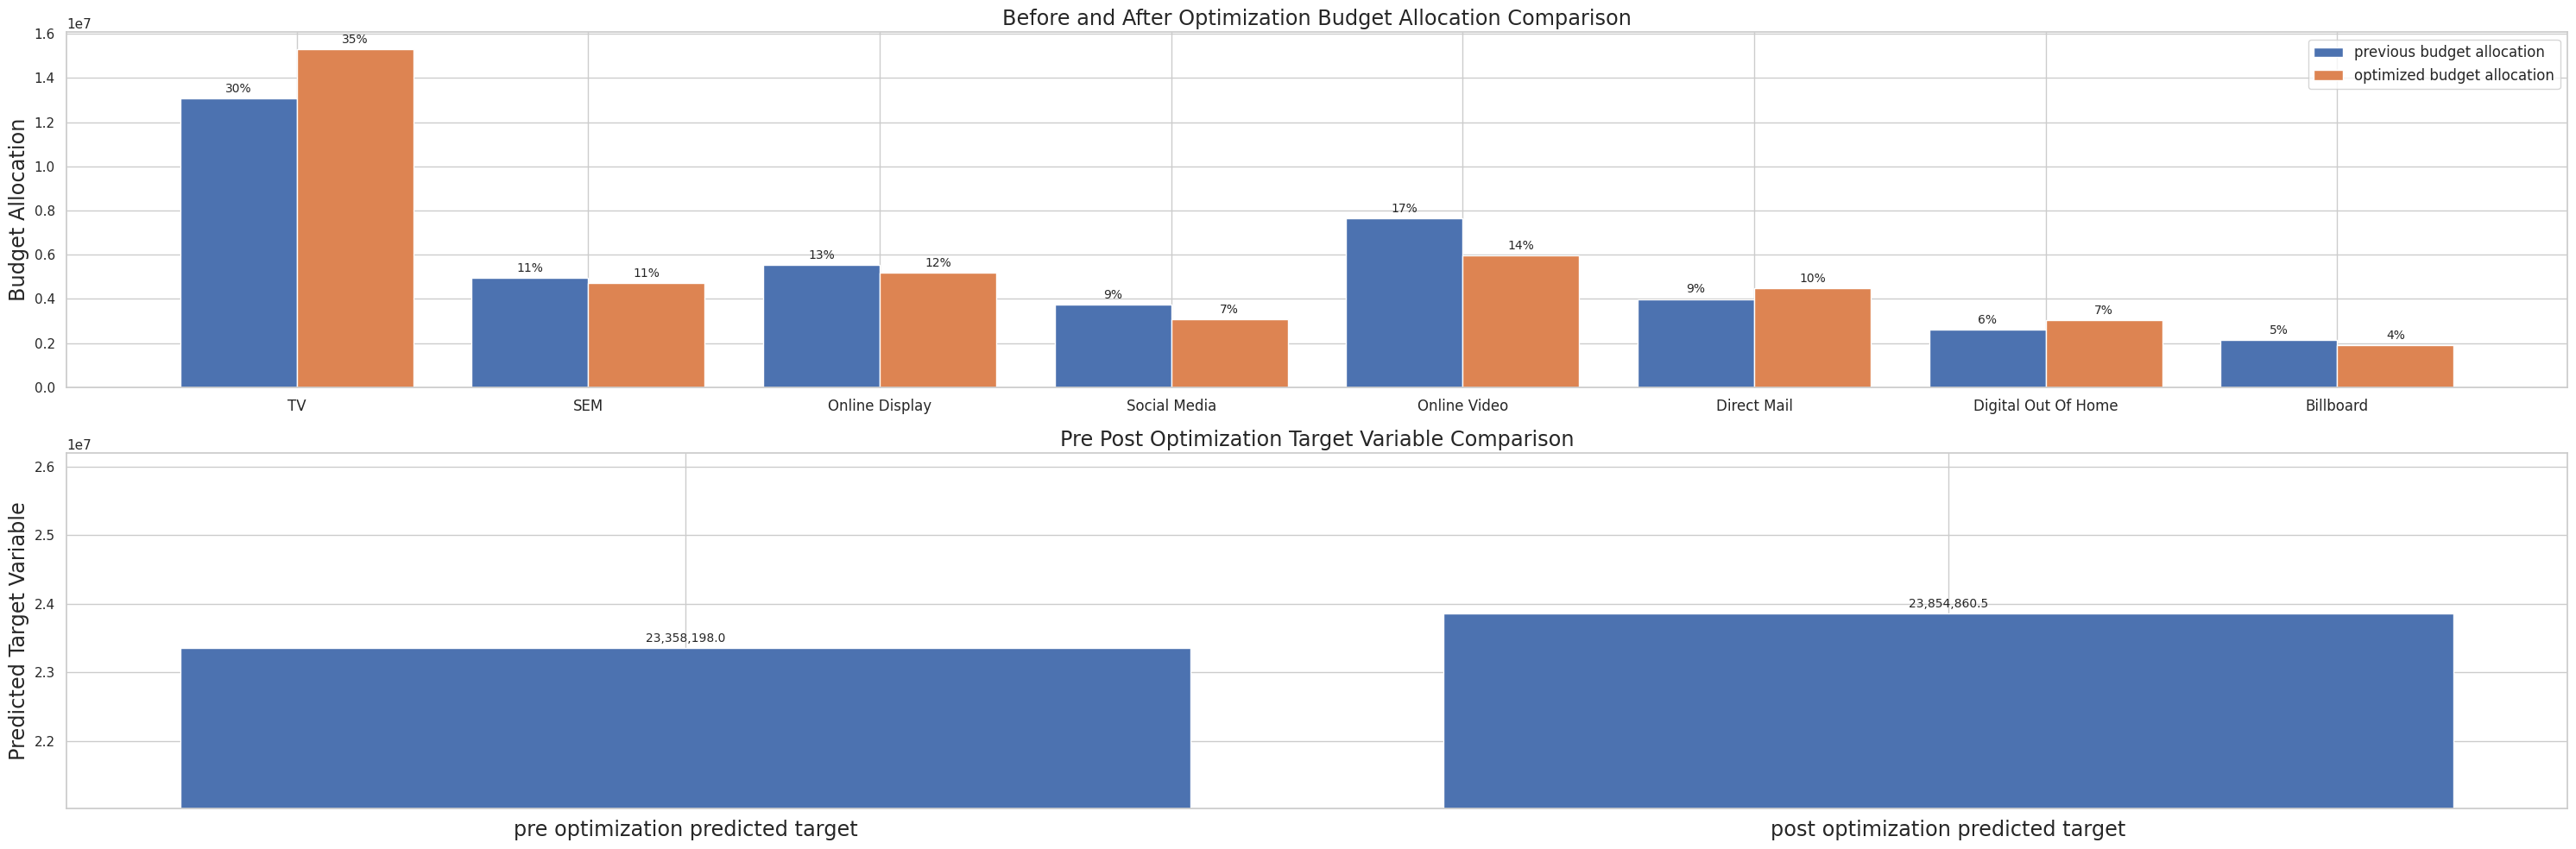

In [ ]:
# Plot pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation,
                                                previous_budget_allocation=previous_budget_allocation,
                                                figure_size=(30,10),
                                                channel_names = dsp_cols)


###**Optimization Results: 6.3% Brand Sales Improvement Through Strategic Budget Reallocation**

The media mix optimization analysis reveals a meaningful opportunity to improve performance by reallocating budget across channels. The model simulation predicts a 6.28% increase in target variable through strategic shifts.
###Key Budget Reallocation Recommendations

####Increase Investment:
* TV: +2% budget increase (maintaining dominance as top performer)
* Direct Mail: +1% budget boost to capitalize on proven mid-tier performance

####Decrease Investment:

* Online Video: -3% reduction (17% → 14%) despite strong historical performance
* Social Media: -2% reduction, suggesting saturation at current spend levels
* Digital Out of Home & Billboard: Minor adjustments reflecting optimization at the margins


##Business Impact
This is expected to result in 1,496,524 more brand sales over two years, from 22,358,139 to 23,854,663.

The 6.3% performance lift represents meaningful incremental value with minimal risk, as all changes stay within ±20% bounds of historical spending patterns. This conservative optimization approach ensures implementable recommendations while capturing measurable improvement opportunities across the media portfolio.


## Save and Load Model


In [ ]:
# Save model to disk.
file_path = "mmm.pkl"
utils.save_model(marketing_mix_model=mmm, file_path=file_path)

In [ ]:
# Once saved, load the model.
load_mmm = utils.load_model(file_path=file_path)